In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/stock_prediction')
from google.colab import files

# Step 1: Read Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# reading the data
# this dataset is downloaded from Kaggle
# list of companies can be obtained from 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
raw = pd.read_csv('/content/drive/My Drive/Colab Notebooks/stock_prediction/all_stocks_5yr.csv')
raw.head()
target = raw[raw['Name']=='EBAY'].close.values


In [ ]:
target

array([56.62, 56.41, 56.78, ..., 42.37, 42.79, 42.33])

## normalize the data to within the range of 0 to 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler(feature_range = (0, 1))

# scale the data
target = target.reshape(target.shape[0], 1)
target = scale.fit_transform(target)
target

array([[0.78161698],
       [0.77687444],
       [0.78523035],
       ...,
       [0.45980126],
       [0.46928636],
       [0.45889792]])

# Step 2: Create a Sliding Window for RNN model

In [ ]:
# T is the window size
def window(input, T):
    X, Y = [], []
    for i in range(len(input) - T - 1):
        X.append(input[i: (i + T), 0])
        Y.append(input[(i + T), 0])
    return np.array(X), np.array(Y)

window_size = 7
X, y = window(target, window_size)

# Step 3: Split dataset into training and testing

In [ ]:
X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Step 4: RNN model

In [ ]:

# MSE loss

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

class my_RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(my_RNN, self).__init__()
        self.num_directions = bidirectional+1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)
        
        return outs, hidden_state



input_size = 7
hidden_size = 64
layers_num = 3
output_size = 1
batch_size = 128

learning_rate = 0.001
epochs_num = 1000

rnn = my_RNN(input_size, hidden_size, layers_num, output_size, bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

loss_hist = []
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()

for epoch in range(epochs_num):
    rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state) 

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()                    
    optimiser.step()               
    if epoch % 20 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    loss_hist.append(loss.item())



epoch 0, loss 0.3105853796005249, eval loss 0.06995240598917007
epoch 1, loss 0.2821696400642395
epoch 2, loss 0.2545096278190613
epoch 3, loss 0.22715429961681366
epoch 4, loss 0.19922983646392822
epoch 5, loss 0.17005613446235657
epoch 6, loss 0.14046165347099304
epoch 7, loss 0.11056028306484222
epoch 8, loss 0.08269628137350082
epoch 9, loss 0.06179216131567955
epoch 10, loss 0.059648431837558746
epoch 11, loss 0.08296152204275131
epoch 12, loss 0.09244342148303986
epoch 13, loss 0.08089377731084824
epoch 14, loss 0.06533319503068924
epoch 15, loss 0.05560412257909775
epoch 16, loss 0.05185630917549133
epoch 17, loss 0.05243831127882004
epoch 18, loss 0.05436542630195618
epoch 19, loss 0.05464845523238182
epoch 20, loss 0.054814938455820084, eval loss 0.0075022513046860695
epoch 21, loss 0.05310134217143059
epoch 22, loss 0.04881315305829048
epoch 23, loss 0.042899973690509796
epoch 24, loss 0.037261247634887695
epoch 25, loss 0.03202800825238228
epoch 26, loss 0.028036877512931824

# Step 5: Check the performance

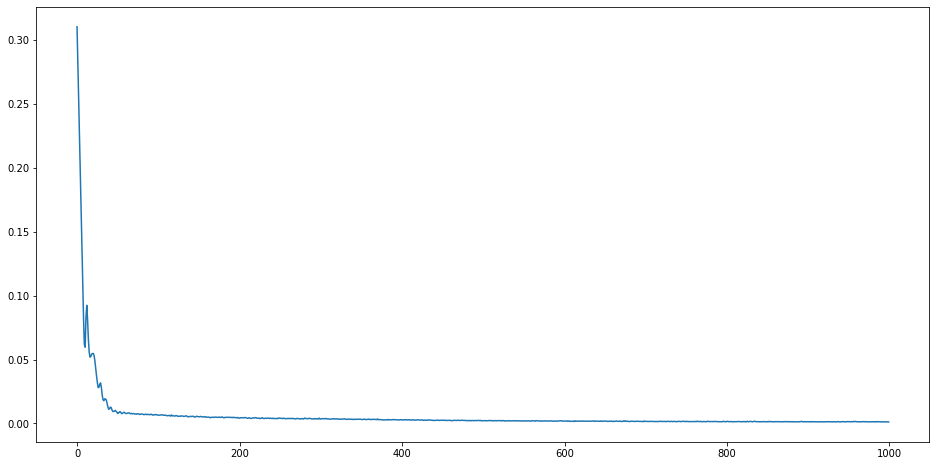

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(loss_hist)

In [ ]:
rnn.eval()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

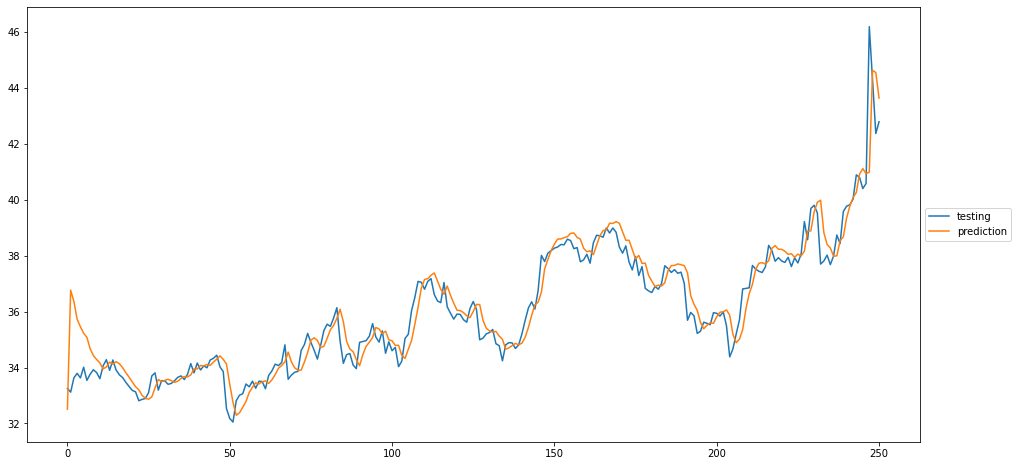

In [ ]:
rnn.eval()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()
plt.figure(figsize=(16,8))
plt.plot(scale.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scale.inverse_transform(test_predict_cpu.reshape(-1,1)))
plt.legend(['testing','prediction'], loc='center left', bbox_to_anchor=(1, 0.5))

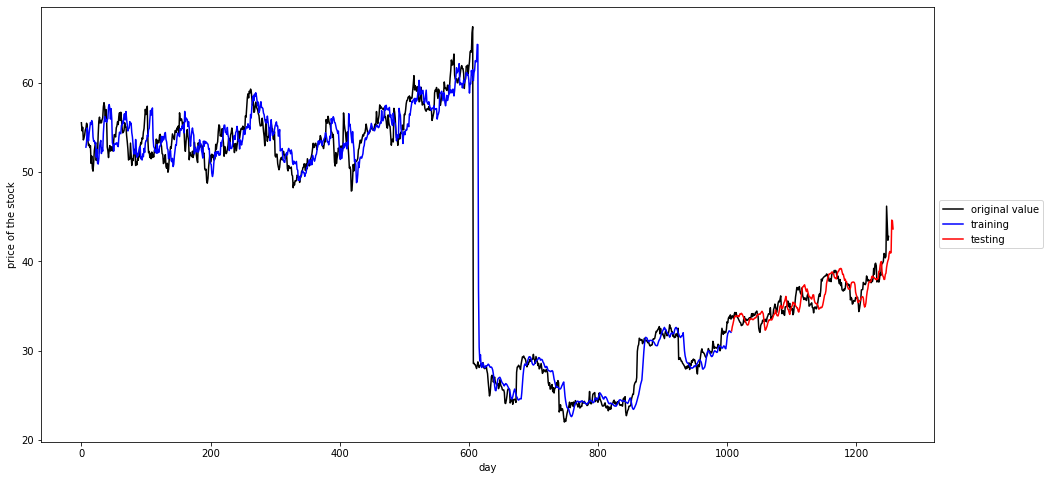

In [ ]:
plt.figure(figsize=(16,8))
#original data
plt.plot(scale.inverse_transform(y.reshape(-1,1)), color='k')

train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

split_pt = int(X.shape[0] * 0.80) + 7 
plt.plot(np.arange(7, split_pt, 1), scale.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), scale.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')


plt.xlabel('day')
plt.ylabel('price of the stock')
plt.legend(['original value','training','testing'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()